# Multiscale Centrality Analysis: EDA & Processing OS OpenRoads GPKG

In [1]:
# load packages for analysis
import ast
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from xml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm

# 1. Determine layers contained in GeoPackage

In [2]:
# print layers in the geoackage to determine what we need
layer_names = fiona.listlayers('Data/oproad_gpkg_gb/Data/oproad_gb.gpkg')
print("Layers in the GeoPackage:", layer_names)

Layers in the GeoPackage: ['motorway_junction', 'road_link', 'road_node']


There are 3 layers contained within this OS OpenRoads Dataset 'motorway_junction', 'road_link', 'road_node'. They are defined below:
1. **road_link (Edge):** Linear segments of the road network, carrying traffic and connecting nodes.
2. **motorway_junction (Node):** Key transition points on motorways, allowing entry and exit.
3. **road_node (Node):** Intersection points of road links, essential for network topology and connectivity.

We will read them all in as different datatsets below.

# 2. Read in layers of GeoPackage

In [3]:
# read in 'motorway_junction' layer & print info
mwjunction_gdf = gpd.read_file('Data/oproad_gpkg_gb/Data/oproad_gb.gpkg', layer='motorway_junction')
mwjunction_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               666 non-null    object  
 1   junction_number  666 non-null    object  
 2   geometry         666 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 15.7+ KB


In [4]:
# read in 'road_node' layer & print info
roadnode_gdf = gpd.read_file('Data/oproad_gpkg_gb/Data/oproad_gb.gpkg', layer='road_node')
roadnode_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3294789 entries, 0 to 3294788
Data columns (total 3 columns):
 #   Column             Dtype   
---  ------             -----   
 0   id                 object  
 1   form_of_road_node  object  
 2   geometry           geometry
dtypes: geometry(1), object(2)
memory usage: 75.4+ MB


In [5]:
# read in 'road_link' layer & print info
roadlinks_gdf = gpd.read_file('Data/oproad_gpkg_gb/Data/oproad_gb.gpkg', layer='road_link')

In [6]:
roadlinks_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3903904 entries, 0 to 3903903
Data columns (total 21 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   id                          object  
 1   fictitious                  bool    
 2   road_classification         object  
 3   road_function               object  
 4   form_of_way                 object  
 5   road_classification_number  object  
 6   name_1                      object  
 7   name_1_lang                 object  
 8   name_2                      object  
 9   name_2_lang                 object  
 10  road_structure              object  
 11  length                      float64 
 12  length_uom                  object  
 13  loop                        bool    
 14  primary_route               bool    
 15  trunk_road                  bool    
 16  start_node                  object  
 17  end_node                    object  
 18  road_number_toid            object

# 3. Convert GeoPackage into NetworkX .graph

In [7]:
# def func. to convert geometry to wkt
def convert_geometry(geometry):
    if geometry:
        return geometry.wkt
    return None

# func. to ensure all attributes are strings / remove unsupported types
def ensure_string_attributes(data):
    return {k: str(v) for k, v in data.items() if v is not None}

# init. networkx graph
G = nx.Graph()

# add nodes from roadnode_gdf layer
for idx, row in roadnode_gdf.iterrows():
    node_data = {
        'pos': (row.geometry.x, row.geometry.y),
        'form_of_road_node': row['form_of_road_node'],
        'geometry': convert_geometry(row.geometry)
    }
    G.add_node(row['id'], **ensure_string_attributes(node_data))

# add nodes from mwjunction_gdf layer
for idx, row in mwjunction_gdf.iterrows():
    node_data = {
        'pos': (row.geometry.x, row.geometry.y),
        'junction_number': row['junction_number'],
        'geometry': convert_geometry(row.geometry)
    }
    G.add_node(row['id'], **ensure_string_attributes(node_data))

# add edges from roadlinks_gdf layer
for idx, row in roadlinks_gdf.iterrows():
    edge_data = {
        'length': row['length'],
        'road_classification': row['road_classification'],
        'road_function': row['road_function'],
        'form_of_way': row['form_of_way'],
        'primary_route': row['primary_route'],
        'trunk_road': row['trunk_road'],
        'road_structure': row['road_structure'],
        'geometry': convert_geometry(row.geometry)
    }
    G.add_edge(row['start_node'], row['end_node'], **ensure_string_attributes(edge_data))

In [8]:
# check size of G
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 3295455
Number of edges: 3854671


In [9]:
# print sample of nodes & edges
sample_nodes = list(G.nodes(data=True))[0]
print("\nSample nodes:")
for node in sample_nodes:
    print(node)
    
sample_edges = list(G.edges(data=True))[0]
print("\nSample edges:")
for edge in sample_edges:
    print(edge)


Sample nodes:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
{'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)'}

Sample edges:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
D3B5B123-54B7-467E-8C60-BE2383A3624B
{'length': '179.0', 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': 'False', 'trunk_road': 'False', 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'}


In [10]:
# convert 'lenght' to float64 and boolean values to bool
def convert_to_bool(value):
    if isinstance(value, str):
        if value.lower() in ['true', '1']:
            return True
        elif value.lower() in ['false', '0']:
            return False
    return value

def convert_edge_attributes(attributes):
    if 'length' in attributes:
        attributes['length'] = float(attributes['length'])
    if 'primary_route' in attributes:
        attributes['primary_route'] = convert_to_bool(attributes['primary_route'])
    if 'trunk_road' in attributes:
        attributes['trunk_road'] = convert_to_bool(attributes['trunk_road'])
    return attributes

# convert node attributes
for node, attributes in G.nodes(data=True):
    pass

# convert edge attributes
for u, v, attributes in G.edges(data=True):
    converted_attributes = convert_edge_attributes(attributes)
    nx.set_edge_attributes(G, {(u, v): converted_attributes})

In [11]:
# save graph in GML format
nx.write_graphml(G, 'Data/road_network.graphml')

# Check & Process new Graph file

Check and process newly created graphml file to ensure it was correctly defined and fit for use

In [12]:
# read in uk street network data
# G = nx.read_graphml("Data/road_network.graphml")

In [13]:
# print node / edge count
print(G)

# get 'node' attributes
list(G.nodes(data=True))[0]

Graph with 3295455 nodes and 3854671 edges


('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)'})

In [25]:
# get edge attributes
list(G.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': <LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, ...>,
  'source': 'CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
  'target': 'D3B5B123-54B7-467E-8C60-BE2383A3624B'})

## Process graph in order to check

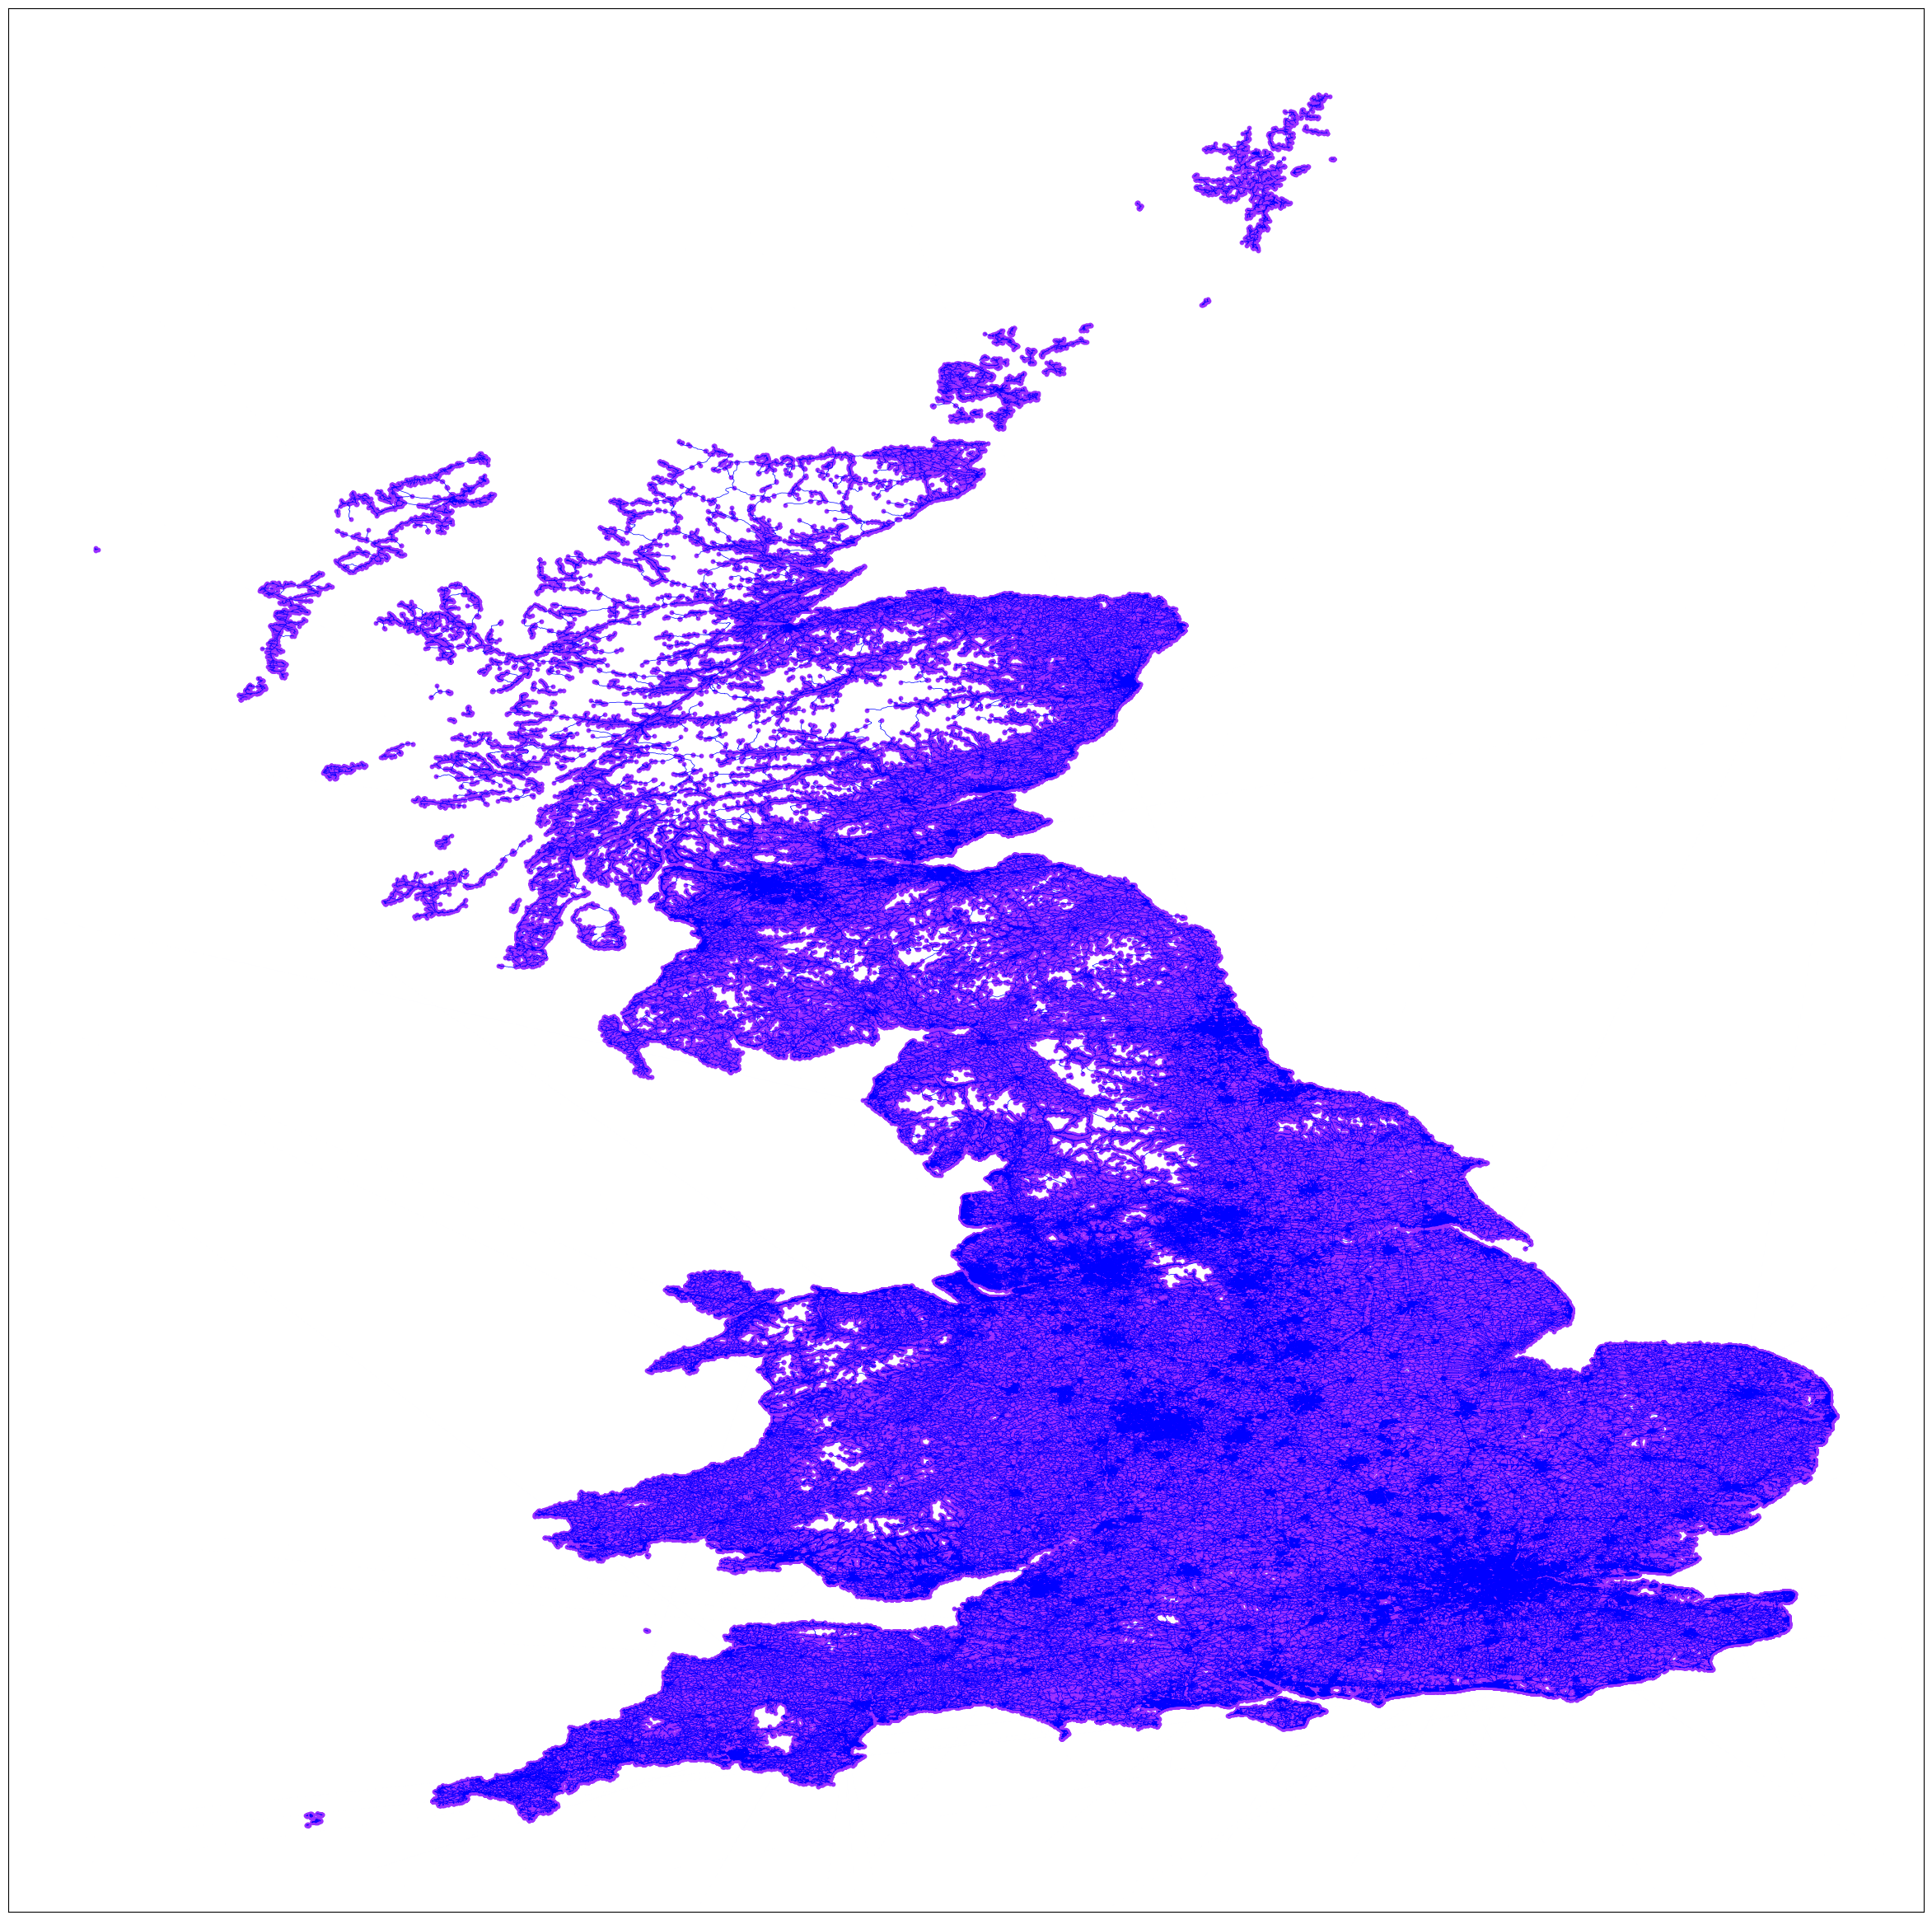

In [27]:
# define function to convert WKT format to tuples
def parse_linestring(geometry):
    if isinstance(geometry, str):
        line = shapely.wkt.loads(geometry)
        return list(line.coords)
    elif isinstance(geometry, LineString):
        return list(geometry.coords)
    else:
        raise ValueError(f"Unexpected geometry type: {type(geometry)}")

# get node positions from the 'pos' attribute
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G.nodes(data=True)}

# get edges & geometry converted to coordinate lists
lines = [parse_linestring(data['geometry']) for u, v, data in G.edges(data=True) if 'geometry' in data]

# LineCollection from the list of lines
lc = LineCollection(lines, colors='blue', linewidths=0.5)
fig, ax = plt.subplots(figsize=(30, 30))

# plot nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="#9B30FF", ax=ax)

# LineCollection to the plot
ax.add_collection(lc)

plt.show()

## Convert Edges and Nodes into a gdf

In [29]:
def parse_geometry(geom):
    if isinstance(geom, str):
        coords = geom.split('(')[1].split(')')[0].split()
        x, y = float(coords[0]), float(coords[1])
        return Point(x, y)
    elif isinstance(geom, Point):
        return geom
    else:
        raise ValueError(f"Unexpected geometry type: {type(geom)}")

# gdf for nodes
nodes = []
for node, data in G.nodes(data=True):
    geom = parse_geometry(data['geometry'])
    data.update({'node': node, 'geometry': geom})
    nodes.append(data)

gdf_nodes = gpd.GeoDataFrame(nodes, geometry='geometry')

gdf_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3295455 entries, 0 to 3295454
Data columns (total 5 columns):
 #   Column             Dtype   
---  ------             -----   
 0   pos                object  
 1   form_of_road_node  object  
 2   geometry           geometry
 3   node               object  
 4   junction_number    object  
dtypes: geometry(1), object(4)
memory usage: 125.7+ MB


In [30]:
gdf_nodes.head()

,pos,form_of_road_node,geometry,node,junction_number
0,"(187422.39, 887423.74)",junction,POINT (187422.390 887423.740),CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D,NaN
1,"(171721.2, 802335.09)",junction,POINT (171721.200 802335.090),D7483B07-F0F6-4EFB-BF02-C6108ACED8AA,NaN
2,"(181912.23, 854134.01)",road end,POINT (181912.230 854134.010),B3F906A0-6D6E-44DB-8692-489327403098,NaN
3,"(290978.0, 903706.0)",junction,POINT (290978.000 903706.000),B6EEEB6E-3372-4E7F-9A2E-1887A526EACC,NaN
4,"(275210.8, 936941.98)",road end,POINT (275210.800 936941.980),E8C40E45-D675-443F-B718-CA9C042CD5B2,NaN


In [32]:
def parse_linestring(geom):
    if isinstance(geom, str):
        coords = geom.split('(')[1].split(')')[0].split(',')
        points = [tuple(map(float, point.split())) for point in coords]
        return LineString(points)
    elif isinstance(geom, LineString):
        return geom
    else:
        raise ValueError(f"Unexpected geometry type: {type(geom)}")

# gdf for edges
edges = []
for u, v, data in G.edges(data=True):
    geom = parse_linestring(data['geometry'])
    data.update({'source': u, 'target': v, 'geometry': geom})
    edges.append(data)

gdf_edges = gpd.GeoDataFrame(edges, geometry='geometry')

gdf_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3854671 entries, 0 to 3854670
Data columns (total 10 columns):
 #   Column               Dtype   
---  ------               -----   
 0   length               float64 
 1   road_classification  object  
 2   road_function        object  
 3   form_of_way          object  
 4   primary_route        bool    
 5   trunk_road           bool    
 6   geometry             geometry
 7   source               object  
 8   target               object  
 9   road_structure       object  
dtypes: bool(2), float64(1), geometry(1), object(6)
memory usage: 242.6+ MB


In [33]:
gdf_edges.head()

,length,road_classification,road_function,form_of_way,primary_route,trunk_road,geometry,source,target,road_structure
0,179.0,Unknown,Restricted Local Access Road,Single Carriageway,False,False,"LINESTRING (187422.390 887423.740, 187436.120 ...",CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D,D3B5B123-54B7-467E-8C60-BE2383A3624B,NaN
1,104.0,Unknown,Restricted Local Access Road,Single Carriageway,False,False,"LINESTRING (187422.390 887423.740, 187422.970 ...",CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D,BAB6A666-D038-4A42-871C-529D9903DDEB,NaN
2,701.0,Unknown,Restricted Local Access Road,Single Carriageway,False,False,"LINESTRING (187565.000 888077.000, 187541.330 ...",CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D,F2E3574A-E4FD-49D0-ADAB-99C71D5A032D,NaN
3,623.0,Unknown,Restricted Local Access Road,Single Carriageway,False,False,"LINESTRING (172152.020 802679.980, 172051.690 ...",D7483B07-F0F6-4EFB-BF02-C6108ACED8AA,C9A5BC53-F019-4B1B-9B13-B8F571F496D6,NaN
4,444.0,Unknown,Restricted Local Access Road,Single Carriageway,False,False,"LINESTRING (171721.200 802335.090, 171717.760 ...",D7483B07-F0F6-4EFB-BF02-C6108ACED8AA,05CEFDED-9C93-4291-B7E7-1980B8D56E0C,NaN


In [34]:
# nonnull & null values in the geometry column of nodes
null_geometries_nodes = gdf_nodes['geometry'].isnull().sum()
print(f"Number of null geometries in nodes: {null_geometries_nodes}")
non_null_geometries_nodes = gdf_nodes['geometry'].notnull().sum()
print(f"Number of non-null geometries in nodes: {non_null_geometries_nodes}")

# null values in the geometry column of edges
null_geometries_edges = gdf_edges['geometry'].isnull().sum()
print(f"Number of null geometries in edges: {null_geometries_edges}")

# non-null values in the geometry column of edges
non_null_geometries_edges = gdf_edges['geometry'].notnull().sum()
print(f"Number of non-null geometries in edges: {non_null_geometries_edges}")

# check for 0s
zero_geometries_nodes = gdf_nodes[gdf_nodes['geometry'].is_empty].shape[0]
print(f"Number of zero geometries in nodes: {zero_geometries_nodes}")

zero_geometries_edges = gdf_edges[gdf_edges['geometry'].is_empty].shape[0]
print(f"Number of zero geometries in edges: {zero_geometries_edges}")

Number of null geometries in nodes: 0
Number of non-null geometries in nodes: 3295455
Number of null geometries in edges: 0
Number of non-null geometries in edges: 3854671
Number of zero geometries in nodes: 0
Number of zero geometries in edges: 0


#### Convert WKT to tuples before saving as new graph

Our data exploration shows the quality of the data we have a complete file with 0 null values for our nodes or edges

We now proceed with the next stage of our analysis which is contained in notebook *3. Percolation Analysis*.